# Data Science Portfolio: Telecom Churn Prediction

**Author:** Jasper Sylvestre  
**Date:** April 8th, 2024

**Description:** The notebook aims to predict customer churn (i.e., when customers switch from one telecom service provider to another) based on relevant features in the telecom datasets found on  __[Kaggle](https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets)__. A summary and list of conclusions are provided at the end.

**Version:** 1.0  
**Dependencies:**
- python 3.12.2
- ipykernel 6.29.3
- ipython 8.22.1
- jupyter_client 8.6.0
- jupyter_core 5.7.1
- matplotlib 3.8.3
- numpy 1.26.4
- pandas 2.2.0
- scikit-learn 1.4.1.post1
- scipy 1.12.0
- seaborn 0.13.2
- xgboost 2.0.3

**Acknowledgments:**  
- Datasets provided by Baligh Mnassri.

**License:** MIT License  
**Contact:** jesylvestre0@gmail.com

# Introduction

The notebook aims to predict customer churn (i.e., when customers switch from one telecom service provider to another) based on relevant features in the telecom datasets found on Kaggle. These datasets are available [here](https://www.kaggle.com/datasets/mnassrib/telecom-churn-datasets).

The data is split into a training and validation dataset for cross-validation, i.e. `churn-bigml-80.csv` with 80% of the total data, and the testing dataset, i.e. `churn-bigml-20.csv` with 20% of the total data.

We will begin by importing necessary libraries to conduct data science and machine learning procedures.

In [1]:
# Imports
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import uniform, randint, zscore
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    f1_score,
    matthews_corrcoef,
    cohen_kappa_score,
)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

# Reading in the Data and Initial Inspection

We will import the datasets that are in the CSV format and are in the "data" folder, with separate training / validation and testing datasets. The target variable is the `Churn` column and all other variables are predictors. We will inspect the data.

We can see that the data is roughly split 80% for training data and 20% for testing data, as is described on the Kaggle description page for these datasets. We can examine the first five values of each dataset. Notably, the `State` variable is categorical, so we will need to one-hot encode this variable to be usable in the model. This is also true for `Area code` variable, although it appears as an integer when read in. All other categorical variables are binary and can also have one-hot encoding applied for modeling. All other predictors are ordinal numeric variables and will require scaling.

We can also examine that the `Churn` values are relatively imbalanced. To deal with this, we will: adjust class weights during the training of the XGBoost model; use stratified random sampling when splitting the data into training and validation datasets; and use AUC score as the evaluation metric during the training of the XGBoost model. This will be the initial approach that should counter some of the difficulties of modeling while having imbalanced classes. If the results of the model are not satisfying, other approaches could be attempted such as over-sampling and under-sampling methods.

In [2]:
# Read data
train_path = "../data/churn-bigml-80.csv"
train_df = pd.read_csv(train_path)

test_path = "../data/churn-bigml-20.csv"
test_df = pd.read_csv(test_path)

In [3]:
# Examine data
display(train_df.head(5))
print()
train_df.info()
print()

display(test_df.head(5))
print()
test_df.info()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null  

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge      667 non-null    f

In [4]:
# Find categorical columns
categorical_columns = train_df.select_dtypes(include=["object"]).columns

# Get value counts for each categorical variable
for column in categorical_columns:
    print(f"There are {len(train_df[column].unique())} unique values for {column}:")
    print(train_df[column].unique())
    print()

There are 51 unique values for State:
['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'WV' 'RI' 'IA' 'MT' 'ID' 'VT' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'NE' 'WY' 'IL' 'NH' 'LA' 'GA' 'AK' 'MD' 'AR' 'WI'
 'OR' 'DE' 'IN' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'NY' 'KY'
 'ME' 'MS' 'MI' 'SC' 'TN' 'PA' 'HI' 'ND' 'CT']

There are 2 unique values for International plan:
['No' 'Yes']

There are 2 unique values for Voice mail plan:
['Yes' 'No']



In [5]:
# Examine class balance
display(train_df["Churn"].value_counts())
print()
display(test_df["Churn"].value_counts())

Churn
False    2278
True      388
Name: count, dtype: int64

Churn
False    572
True      95
Name: count, dtype: int64

# Data Cleaning

We will check for duplicate values across all variables and for duplicate values across all variables except `Churn` for both training and testing datasets. We can examine that there are none whatsoever

We will check for missing values across all variables for both training and testing datasets. We can examine that there are none whatsoever.

We will also check for outliers using the Z-Score method, a robust technique for detecting outliers. Applying this method, we can examine there are some outliers across every ordinal numeric variable. It is worth noting that XGBoost is relatively robust to outliers relative to other algorithms such as linear regression. However, we will create a dataframe without the outliers stored as `cleaned_df` and will examine the results from training a model using this dataset versus the dataset containing outliers.

In [6]:
# Show duplicate count
## Training dataset
print(f"There are {train_df.duplicated().sum()} duplicate entries across all columns in the training dataset.")
print(f"There are {train_df.drop(columns="Churn").duplicated().sum()} duplicate entries across all columns in the training dataset `Churn`.\n")

## Testing dataset
print(f"There are {test_df.duplicated().sum()} duplicate entries across all columns in the testing dataset.")
print(f"There are {test_df.drop(columns="Churn").duplicated().sum()} duplicate entries across all columns in the testing dataset `Churn`.")

There are 0 duplicate entries across all columns in the training dataset.
There are 0 duplicate entries across all columns in the training dataset `Churn`.

There are 0 duplicate entries across all columns in the testing dataset.
There are 0 duplicate entries across all columns in the testing dataset `Churn`.


In [7]:
# Show missing values count
print(f"There are {train_df.isnull().sum().sum()} missing values across all columns in the training dataset.")
print(f"There are {test_df.isnull().sum().sum()} missing values across all columns in the testing dataset.")

There are 0 missing values across all columns in the training dataset.
There are 0 missing values across all columns in the testing dataset.


In [8]:
# Convert `Area code` to object variable
train_df["Area code"] = train_df["Area code"].astype("object")
test_df["Area code"] = test_df["Area code"].astype("object")

# Find numeric variables
numeric_variables = train_df.select_dtypes(include=np.number)

# Check for outliers
for col in numeric_variables:
    z_scores = zscore(train_df[col])
    outlier_indices = np.where(np.abs(z_scores) > 3)[0]
    print(f"There are {len(outlier_indices)} outliers in the '{col}' variable.")

There are 6 outliers in the 'Account length' variable.
There are 2 outliers in the 'Number vmail messages' variable.
There are 9 outliers in the 'Total day minutes' variable.
There are 4 outliers in the 'Total day calls' variable.
There are 9 outliers in the 'Total day charge' variable.
There are 7 outliers in the 'Total eve minutes' variable.
There are 4 outliers in the 'Total eve calls' variable.
There are 7 outliers in the 'Total eve charge' variable.
There are 9 outliers in the 'Total night minutes' variable.
There are 5 outliers in the 'Total night calls' variable.
There are 9 outliers in the 'Total night charge' variable.
There are 19 outliers in the 'Total intl minutes' variable.
There are 41 outliers in the 'Total intl calls' variable.
There are 19 outliers in the 'Total intl charge' variable.
There are 28 outliers in the 'Customer service calls' variable.


In [9]:
# Find numeric variables
numeric_variables = train_df.select_dtypes(include=np.number)

# Create a dataframe to store outliers
outlier_df = pd.DataFrame()

# Check for outliers
for col in numeric_variables:
    z_scores = zscore(train_df[col])
    outlier_indices = np.where(np.abs(z_scores) > 3)[0]
    
    # Store outliers in the outlier dataframe
    outliers = train_df.iloc[outlier_indices].copy()
    outliers.loc[:, "Outlier_Variable"] = col
    outlier_df = pd.concat([outlier_df, outliers])

# Remove outliers from the original dataframe
clean_df = train_df.drop(outlier_df.index)

# Display cleaned dataframe
display(clean_df)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79,415,No,No,0,134.7,98,22.90,189.7,68,16.12,221.4,128,9.96,11.8,5,3.19,2,False
2662,AZ,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
2663,WV,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
2664,RI,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False


# Data Preprocessing

For testing and training datasets, we need to one-hot encode categorical variables and scale numeric variables. To do this while utilizing cross-validation with stratified random sampling to form training and validation datasets, we will create a pipeline for our data preprocessing techniques. This pipeline requires model specifications, which will be done in the next step. For now, we will form the preprocessing step of the pipeline.

We will form the X dataframes and y series objects for the training dataset with outliers, the training dataset without outliers, and the testing dataset.

In [10]:
# Form X dataframes and y series objects
## For training dataframe with outliers
X = train_df.drop(columns="Churn", axis=1)
y = train_df["Churn"]

## For training dataframe without outliers
X_clean = clean_df.drop(columns="Churn", axis=1)
y_clean = clean_df["Churn"]

## For testing dataframe
X_test = test_df.drop(columns="Churn", axis=1)
y_test = test_df["Churn"]

In [11]:
# Find categorical and numerical features
categorical_features = X.select_dtypes(include=["object"]).columns
numeric_features = X.select_dtypes(include=np.number).columns

In [12]:
# Create preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), numeric_features),  # Scale numeric features
        ("categorical", OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ])

# Display preprocessor
display(preprocessor)

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 Index(['Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls'],
      dtype='object')),
                                ('categorical', OneHotEncoder(),
                                 Index(['State', 'Area code', 'International plan', 'Voice mail plan'], dtype='object'))])

# Training the Model with Cross-Validation

We will adjust the class weights given the imbalance we noted earlier. We will calculate the imbalance ratio then use this approximate value for the hyperparameter `scale_pos_weight` in the model to adjust the class weights and hopefully improve the overall AUC score despite the imbalanced classes.

We will prepare use of a XGBoost model first by using the preprocessor formed in the previous step to form a pipeline. We will use the imbalance ratio from before when defining the model in the pipeline.

We will then define parameter distributions to search over using randomized search. Grid search exhaustively searches across all combinations, but given the number of combinations in here being extremely high if we replaced the distributions with lists of some values across these features, this would take a very long time to train and is not reasonable to perform in this context. Randomized search randomly samples combinations from specified distributions for each hyperparameter. This will be much more efficient in terms of time and computational power.

We will define some hyperparameters and some constants that will stay the same throughout the modeling process. This includes: the random seed (123) for reproducability, the number of folds for cross validation (5), the validation split size (20%), the scoring method (AUC score), and the number of iterations random search will perform (100). We will define the stratified random sampling function in this context using the random seed, the validation split size, and the number of folds.

We will now perform model training using the dataset with outliers and the dataset without outliers. The randomized search functions will first be defined using the pipeline that was formed, the parameter distributions that were formed, the number of iterations, the chosen scoring method, and the chosen random seed for reproducability. Parallel processing is also applied here using the maximum number of CPU cores possible. We will now perform the training of the models.

We will then examine the best parameter values found using randomized search for both models and will examine the best AUC score value found for both models.

We can examine that best AUC score found for the model trained using the dataset not including outliers led to slightly lower results. We will move forward with the model trained using the dataset including outliers.

We will finally display the feature importance of the model we will be moving forward with. This helps quantify the extent to which a feature influences the model's predictions, providing insights into which features are most relevant for making accurate predictions. This helps in interpreting the model further.

In [13]:
# Calculate the imbalance ratio
label_counts = y.value_counts()
imbalance_ratio = label_counts[False] / label_counts[True]
print(f"Imbalance ratio: {imbalance_ratio:.3f}")

Imbalance ratio: 5.871


In [14]:
# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(scale_pos_weight=imbalance_ratio))
])

# Display pipeline
display(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [15]:
# Set up parameter distributions
param_distributions = {
    "classifier__learning_rate": uniform(0.01, 0.1),
    "classifier__max_depth": randint(1, 8),
    "classifier__n_estimators": randint(100, 501),
    "classifier__subsample": uniform(0.7, 0.3),
    "classifier__colsample_bytree": uniform(0.6, 0.4),
    "classifier__gamma": uniform(0, 0.2),
    "classifier__reg_alpha": uniform(0, 0.5),
    "classifier__reg_lambda": uniform(0, 0.5)
}

In [16]:
# Set random seed for reproducability and define constants
RANDOM_SEED = 123
NUM_FOLDS = 5
VAL_SIZE = 0.2
SCORING_METHOD = "roc_auc"
NUM_ITERATIONS = 100

# Set up stratfiied shuffle split
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=NUM_FOLDS,
                                                  test_size=VAL_SIZE,
                                                  random_state=RANDOM_SEED)

In [17]:
# Set up randomized search utilizing the pipeline, parameter grid, stratified shuffle split, and scoring
## Training set with outliers
randomized_search = RandomizedSearchCV(pipeline,
                                       param_distributions,
                                       n_iter=NUM_ITERATIONS,
                                       cv=stratified_shuffle_split,
                                       scoring=SCORING_METHOD,
                                       n_jobs=-1,
                                       random_state=RANDOM_SEED)

## Training set without outliers
randomized_search_clean = RandomizedSearchCV(pipeline,
                                             param_distributions,
                                             n_iter=NUM_ITERATIONS,
                                             cv=stratified_shuffle_split,
                                             scoring=SCORING_METHOD,
                                             n_jobs=-1,
                                             random_state=RANDOM_SEED)

In [18]:
# Train model using dataset with outliers
randomized_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=123, test_size=0.2,
            train_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               StandardScaler(),
                                                                               Index(['Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charg...
                                        'classifier__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022370964DA0>,
                                        'classifier__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022370964FB0>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000223709644A0>},
                   random_state=123, scoring='roc_auc')

In [19]:
# Train model using dataset without outliers
randomized_search_clean.fit(X_clean, y_clean)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=123, test_size=0.2,
            train_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               StandardScaler(),
                                                                               Index(['Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charg...
                                        'classifier__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022370964DA0>,
                                        'classifier__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022370964FB0>,
                                        'classifier__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000223709644A0>},
                   random_state=123, scoring='roc_auc')

In [20]:
# Get the best model trained using data with outliers and print its score and best parameter values
print("For model trained using data with outliers included:\n")

best_model = randomized_search.best_estimator_
for parameter in randomized_search.best_params_:
    if type(randomized_search.best_params_[parameter]) == int:
        print(f"Best value for '{parameter}': {randomized_search.best_params_[parameter]}")    
    else:
        print(f"Best value for '{parameter}': {randomized_search.best_params_[parameter]:.3f}")

print(f"\nBest cross-validation score (AUC): {randomized_search.best_score_:.3f}")

For model trained using data with outliers included:

Best value for 'classifier__colsample_bytree': 0.812
Best value for 'classifier__gamma': 0.125
Best value for 'classifier__learning_rate': 0.042
Best value for 'classifier__max_depth': 6
Best value for 'classifier__n_estimators': 162
Best value for 'classifier__reg_alpha': 0.024
Best value for 'classifier__reg_lambda': 0.121
Best value for 'classifier__subsample': 0.729

Best cross-validation score (AUC): 0.934


In [21]:
# Get the best model trained using data without outliers and print its score and best parameter values
print("For model trained using data without outliers included:\n")

best_model = randomized_search_clean.best_estimator_
for parameter in randomized_search_clean.best_params_:
    if type(randomized_search_clean.best_params_[parameter]) == int:
        print(f"Best value for '{parameter}': {randomized_search_clean.best_params_[parameter]}")
    else:
        print(f"Best value for '{parameter}': {randomized_search_clean.best_params_[parameter]:.3f}")

print(f"\nBest cross-validation score (AUC): {randomized_search_clean.best_score_:.3f}")

For model trained using data without outliers included:

Best value for 'classifier__colsample_bytree': 0.904
Best value for 'classifier__gamma': 0.105
Best value for 'classifier__learning_rate': 0.098
Best value for 'classifier__max_depth': 4
Best value for 'classifier__n_estimators': 387
Best value for 'classifier__reg_alpha': 0.018
Best value for 'classifier__reg_lambda': 0.072
Best value for 'classifier__subsample': 0.939

Best cross-validation score (AUC): 0.903


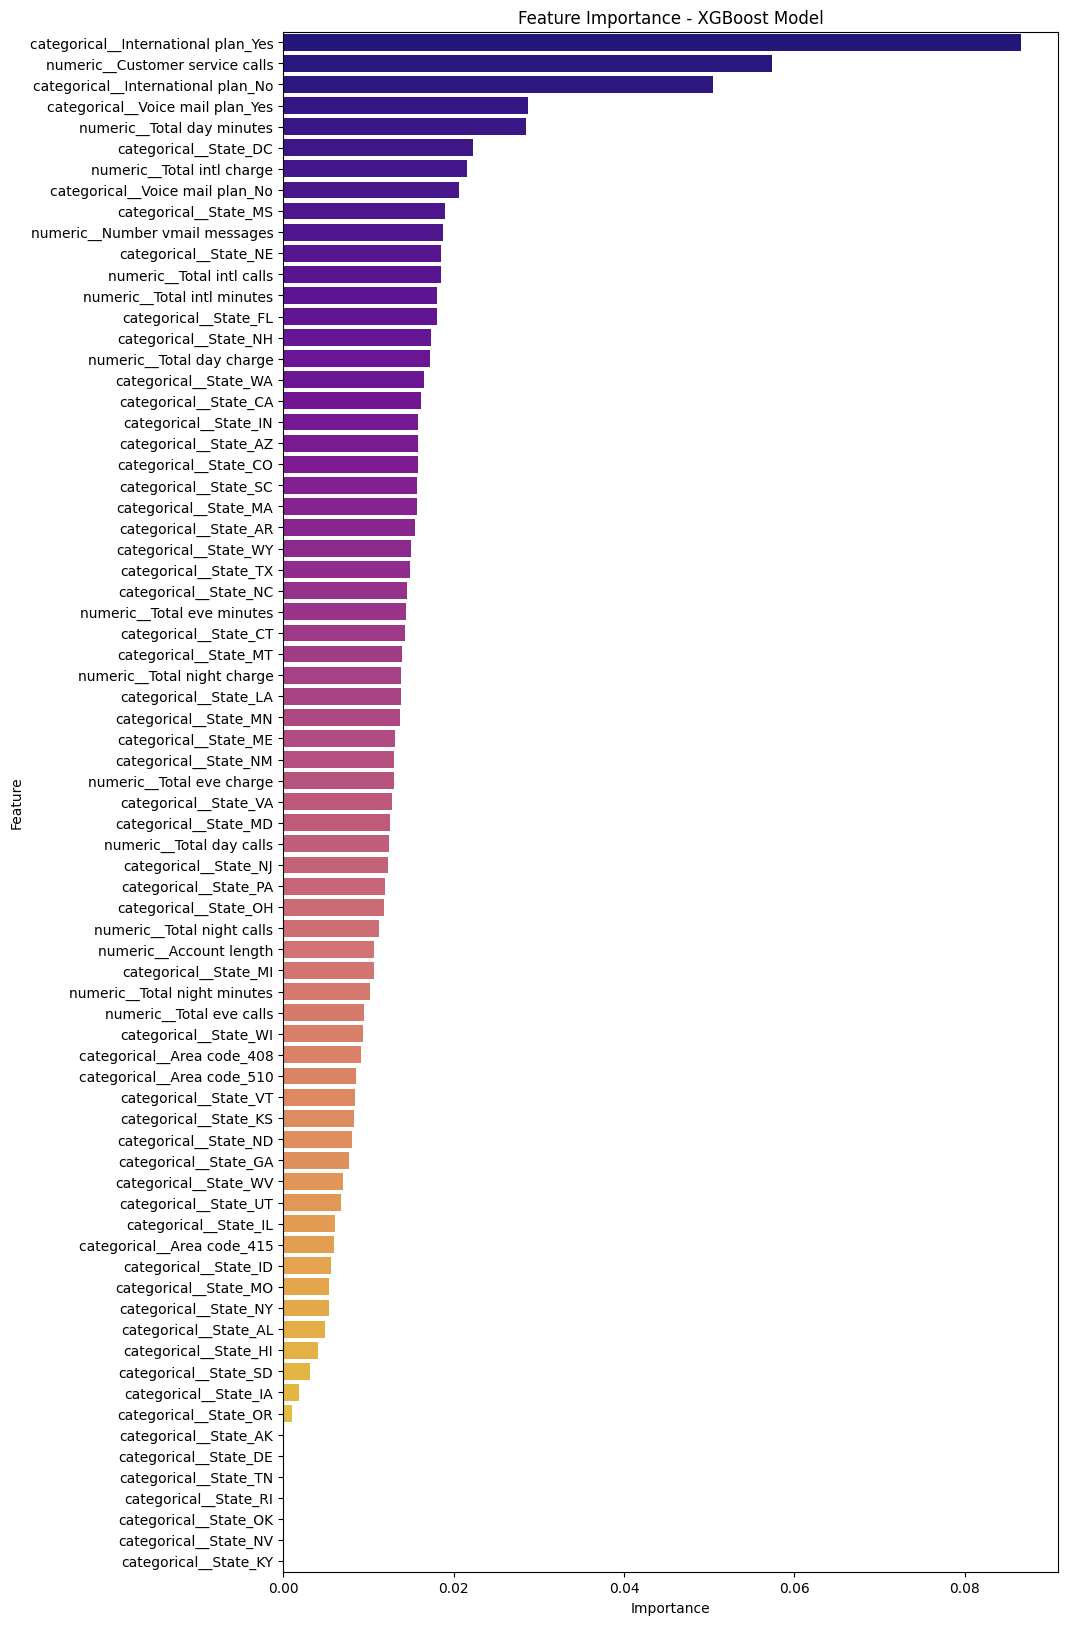

In [22]:
# Get feature importances from the best model
feature_importances = randomized_search.best_estimator_["classifier"].feature_importances_

# Get feature names after preprocessing is performed
preprocessor.fit(X)
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# Create a dataframe for easier plotting
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 20))
warnings.filterwarnings("ignore", category=FutureWarning) # Ignore future warning
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="plasma", dodge=False, legend=False)
warnings.resetwarnings() # Reset warnings
plt.title("Feature Importance - XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Evaluating the Model on the Testing Data

We will fit the preprocessor defined from before using the training dataset including outliers. We will then transform the testing dataset using the fitted preprocessor. We will calculate the y prediction probabilities and the y predictions and convert the testing dataset y values into integer form. The data is now ready to form an ROC curve and a test AUC score can be found.

We will plot an ROC curve and will calculate the test AUC score. We can examine the test AUC score is found to approximately 0.91, and the ROC curve is found to be approximately smooth, to be relatively far above the baseline, and to have a high sensitivity and a high specificity.

We can also examine the values of: F1-score, precision, recall, accuracy, Matthew's correlation coefficient, Cohen's Kappa, and specificity. To summarize the results: the model predicts correctly most of the time; of the positive predictions, most are actually positive, and there are few false positives; the model has very few false negatives; there is a balanced measure of precision and recall; MMC and Cohen's Kappa indicate good performance; there is some room for improvement in capturing all relevant instances of the positive class.

In [23]:
# Fit the preprocessor on the training data
preprocessor.fit(X)

# Transform both the testing data
X_test_transformed = preprocessor.transform(X_test)

# Predict using the best model
y_pred_probs = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]
y_pred = randomized_search.best_estimator_.predict(X_test)

# Convert y_test to integer
y_test_int = y_test.astype(int)

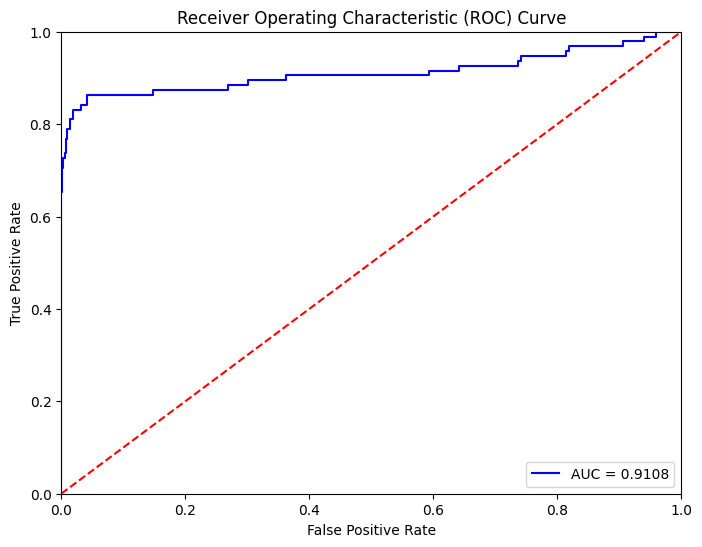

In [24]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_int, y_pred_probs)

# Compute AUC score
auc = roc_auc_score(y_test_int, y_pred_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="b", label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "r--") # Diagonal reference line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [25]:
# Caculate the F1-score, precision, recall, accuracy, Matthew's correlation coefficient, Cohen's Kappa, and specificity
## F1-score
f1 = f1_score(y_test_int, y_pred)

## Precision
precision = precision_score(y_test_int, y_pred)

## Recall
recall = recall_score(y_test_int, y_pred)

## Accuracy
accuracy = accuracy_score(y_test_int, y_pred)

## Matthew's correlation coefficient
mcc = matthews_corrcoef(y_test_int, y_pred)

## Cohen's Kappa
kappa = cohen_kappa_score(y_test_int, y_pred)

## Specificity
TN = ((y_test_int == 0) & (y_pred == 0)).sum() # True Negatives
FP = ((y_test_int == 0) & (y_pred == 1)).sum() # False Positives
specificity = TN / (TN + FP)

## Display values
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Specificity: {specificity:.4f}")

F1-score: 0.8495
Precision: 0.8681
Recall: 0.8316
Accuracy: 0.9580
Matthews Correlation Coefficient (MCC): 0.8253
Cohen's Kappa: 0.8251
Specificity: 0.9790


# Continuing to Improve the Model

To continue improving the model, several strategies can be considered.

1. **Feature Engineering**: The dataset could be explored further to create new features that might have predictive power. This could involve combining existing features, transforming existing features, or creating interaction terms. This could require domain knowledge and consulting experts. Experimentation could be used to examine if new features enhance model performance.
2. **Consulting the Source**: The source of the dataset could be considered, and more information could be attempted to be extracted to add more features. Outliers could be investigated by the source of the dataset to examine if these were all naturally occuring outliers or if sometimes an error was the result of the outlier.
3. **Model Tuning**: Randomized search was already performed, but this might not be exhaustive enough. The search space could be expanded and the number of iterations could be increased. Other forms of hyperparameter optimization could be considered such as Bayesian Optimization.
4. **Ensemble Methods**: Other forms of ensemble forms could be examined to see if there is improvement of model performance, such as Random Forests or other forms of Gradient Boosting Machines.
5. **Handling Imbalanced Data**: Some methods were considered for handling the imbalance in the number of classes, but there could be further investigation in this area, such as up-sampling and down-sampling.
6. **Other Models**: Other models could be considered for this dataset, such as Support Vector Machines and neural networks, to examine if they result in better model performance.
7. **Model Interpretability**: The model's interpretability could be enhanced using techniques such as Local Interpretable Model-agnostic Explanations (LIME) to provide insights into how the model makes predictions, which could help in identifying areas of improvement.
8. **Advanced Techniques**: Techniques such as stacking or blending models. These involve training multiple models and combining their predictions to make final predictions, often resulting in improved performance.

By systematically exploring these different methods and iteratively improving the model based on experimentation and evaluation, we could continue to enhance its predictive performance. Additionally, monitoring the model's performance over time and updating it with new data and techniques can help ensure its continued effectiveness.





# Summary and Conclusions

The notebook presents a comprehensive approach to predicting customer churn in the telecom industry using machine learning techniques. Key steps include data import and initial inspection, data cleaning, data preprocessing, model training with cross-validation, evaluation on testing data, and discussion on further model improvement strategies.

# Conclusions

Here is a list of conclusions based on different steps taken throughout the notebook:

1. **Data Import and Initial Inspection**: The datasets were imported, revealing features related to customer behavior and churn. An initial inspection provided insights into data distribution and structure, preparing for subsequent data analysis.
2. **Data Cleaning**: Duplicate and missing values were checked and addressed appropriately. Outliers were detected using the Z-Score method, and a cleaned dataset was saved for further use.
3. **Data Preprocessing**: Categorical variables were one-hot encoded, and numeric variables were scaled using a preprocessing pipeline, ensuring compatibility with machine learning algorithms.
4. **Model Training with Cross-Validation**: An XGBoost model was trained using randomized search for hyperparameter tuning. Class imbalance was mitigated through strategies such as adjusting class weights and using stratified sampling during cross-validation.
5. **Evaluation on Testing Data**: The best-performing model was evaluated on the testing dataset, yielding promising results with an AUC score of approximately 0.91. Additional metrics, including F1-score, precision, recall, accuracy, Matthews correlation coefficient, Cohen's Kappa, and specificity, provided a comprehensive assessment of model performance.
6. **Continuing Improvement**: Strategies for further model improvement were discussed, including feature engineering, model tuning, ensemble methods, handling imbalanced data, exploring alternative models, enhancing interpretability, and utilizing advanced techniques like stacking or blending models.

Overall, the model demonstrates strong predictive performance with an AUC score of approximately 0.91 on the testing dataset. While the model performs well overall, there is room for improvement in capturing all instances of churn. Future efforts should focus on iteratively enhancing the model through experimentation with various strategies, including feature engineering and model tuning. Continued monitoring and updating of the model with new data and techniques will be crucial for ensuring its effectiveness in predicting telecom churn. The notebook provides a solid foundation for churn prediction in the telecom industry and offers a roadmap for ongoing model refinement and optimization.